<a href="https://colab.research.google.com/github/Yustira/ANN-MT-1D/blob/main/Training_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
class rhoCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss') < 21 :
      print("\nLoss telah dibawah 21")
      self.model.stop_training = True

In [ ]:
class phiCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss') < 3.2 :
      print("\nLoss telah dibawah 3.2")
      self.model.stop_training = True

In [ ]:
def open_data(loc_file):
    period = []
    rho = []
    phi = []

    with open(loc_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            period.append(float(row[0]))
            rho.append(float(row[1]))
            phi.append(float(row[2]))

    period = np.array(period)
    rho = np.array(rho)
    phi = np.array(phi)
        
    return period, rho, phi

In [ ]:
def plot_res_phase(period, rho, phi, rho_forecast=False, phi_forecast=False, 
                   tp1=False, tp2=False, forecast=False):
    fig, ax = plt.subplots(2, 1, figsize=(12, 5*2))

    if forecast == True:
        ax[0].loglog(period, rho, tp1, lw=2, label = "Sampel")
        ax[0].loglog(period, rho_forecast, tp2, lw=2, label = "ANN")
        ax[0].legend(fontsize=10)

        ax[1].semilogx(period, phi, tp1, lw=2, label = "Sampel")
        ax[1].semilogx(period, phi_forecast, tp2, lw=2, label = "ANN")
        ax[1].legend(fontsize=10)
    else:
        ax[0].loglog(period, rho, tp1, lw=2)
        ax[1].semilogx(period, phi, tp1, lw=2)
    
    ax[0].set_title('Distribusi Resistivitas Semu Terhadap Periode', fontsize=16)
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_ylim(3, rho.max()+800)

    ax[1].set_title('Distribusi Fase Terhadap Periode', fontsize=16)
    ax[1].set_ylabel('$\\phi$ ($^\circ$)', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('Periode (s)', fontsize=14)
        a.grid(True, which = 'both', lw=0.5)
        a.set_xlim(period.min(), period.max())
        
    plt.tight_layout()
    plt.show() 

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
def model_forecast(model, series):
    forecast = []
    for i in range(len(series)-window_size):
        forecast.append(model.predict(series[i:i+window_size][np.newaxis]))
    forecast = np.array(forecast)[:, 0, 0]
    return forecast

In [ ]:
def plot_history(history):
    fig, axes = plt.subplots(3, 1, figsize=(6,10))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(['Pelatihan','Validasi'])
    axes[0].grid(True)

    axes[1].plot(history.history['root_mean_squared_error'])
    axes[1].plot(history.history['val_root_mean_squared_error'])
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('RMSE', fontsize=14)
    axes[1].legend(['Pelatihan','Validasi'])
    axes[1].grid(True)

    axes[2].plot(history.history['msle'])
    axes[2].plot(history.history['val_msle'])
    axes[2].set_xlabel('Epochs', fontsize=14)
    axes[2].set_ylabel('MSLE', fontsize=14)
    axes[2].legend(['Pelatihan','Validasi'])
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def error(var1, var2):
    mae = 1/len(var1)*np.sum(np.absolute(np.subtract(var2, var1)))
    return mae

In [ ]:
# Menghubungkan ke google drive untuk mengakses data
drive.mount('/content/gdrive')

Mounted at /content/gdrive


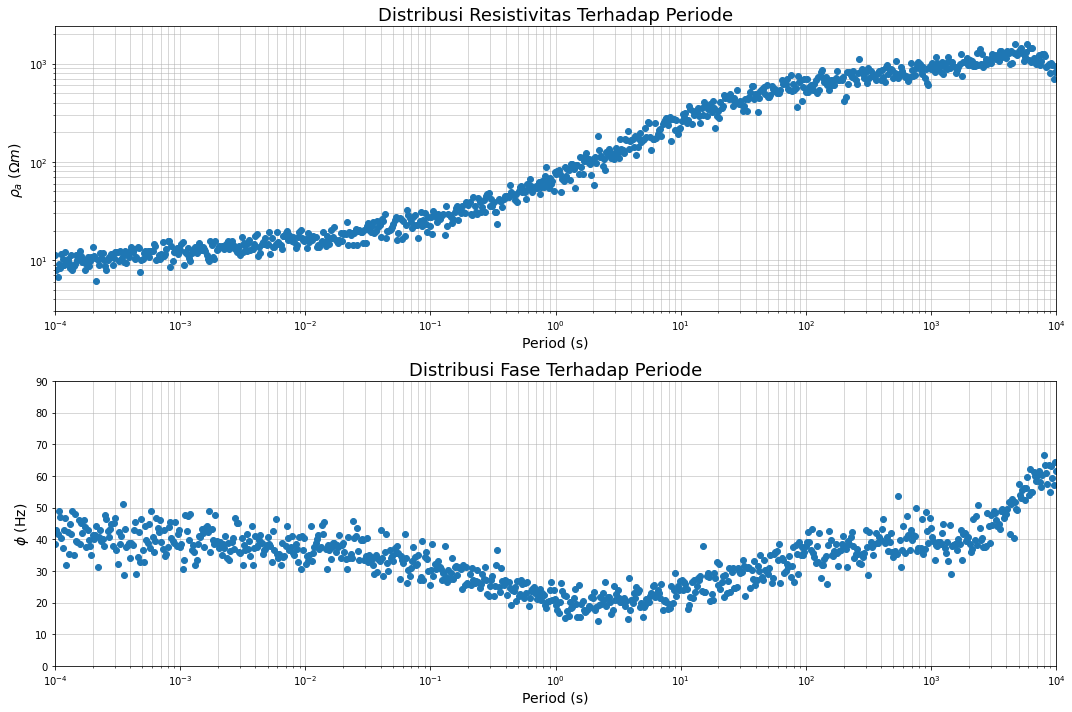

In [ ]:
loc_file = '/content/gdrive/MyDrive/ANN MT 1D/Data/data1.csv' # Lokasi data
period, rho, phi = open_data(loc_file)

# Reverse index array
period = period[::-1]
rho = rho[::-1]
phi = phi[::-1]

plot_res_phase(period, rho, phi, tp1='o')

In [ ]:
split_data = int(len(period)*0.80)

period_train = period[:split_data]
rho_train = rho[:split_data]
phi_train = phi[:split_data]

period_val = period[split_data:]
rho_val = rho[split_data:]
phi_val = phi[split_data:]

print('Jumlah data pelatihan:', period_train.size)
print('Jumlah data evaluasi:', period_val.size)

Jumlah data pelatihan: 640
Jumlah data evaluasi: 160


In [ ]:
window_size = 5
batch_size = 100
shuffle_buffer_size = 100

In [ ]:
train_rho = windowed_dataset(
    rho_train, window_size, batch_size, shuffle_buffer_size
)

val_rho = windowed_dataset(
    rho_val, window_size, batch_size, shuffle_buffer_size
)

In [ ]:
train_phi = windowed_dataset(
    phi_train, window_size, batch_size, shuffle_buffer_size
)

val_phi = windowed_dataset(
    phi_val, window_size, batch_size, shuffle_buffer_size
)

Model ANN untuk resistivitas

In [ ]:
tf.keras.backend.clear_session()

rho_model = Sequential([
    layers.Dense(128, input_shape=[window_size], activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'), 
    layers.Dense(16, activation='relu'),
    layers.Dense(1)                                          
])

rho_model.compile(
    optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.1),
    loss = 'mae', 
    metrics = [keras.metrics.RootMeanSquaredError(), 'msle']
)

rho_history = rho_model.fit(
    train_rho, validation_data=val_rho,
    epochs=1000, verbose=1, callbacks=rhoCallback()
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
7/7 [==============================] - 1s 37ms/step - loss: 144.2187 - root_mean_squared_error: 250.6270 - msle: 8.0055 - val_loss: 956.1841 - val_root_mean_squared_error: 977.7629 - val_msle: 10.8335
Epoch 2/1000
7/7 [==============================] - 0s 18ms/step - loss: 143.6103 - root_mean_squared_error: 249.5930 - msle: 7.5950 - val_loss: 951.9838 - val_root_mean_squared_error: 973.5361 - val_msle: 10.1261
Epoch 3/1000
7/7 [==============================] - 0s 21ms/step - loss: 142.9946 - root_mean_squared_error: 248.5407 - msle: 7.2245 - val_loss: 947.7485 - val_root_mean_squared_error: 969.2753 - val_msle: 9.5052
Epoch 4/1000
7/7 [==============================] - 0s 18ms/step - loss: 142.3733 - root_mean_squared_error: 247.4897 - msle: 6.8862 - val_loss: 943.5942 - val_root_mean_squared_error: 965.0980 - val_msle: 8.9678
Epoch 5/1000
7/7 [==============================] - 0s 20ms/step - loss: 141.7653 - root_mean_squared_error: 246.4520 - msle: 6.5889 - val_loss: 9

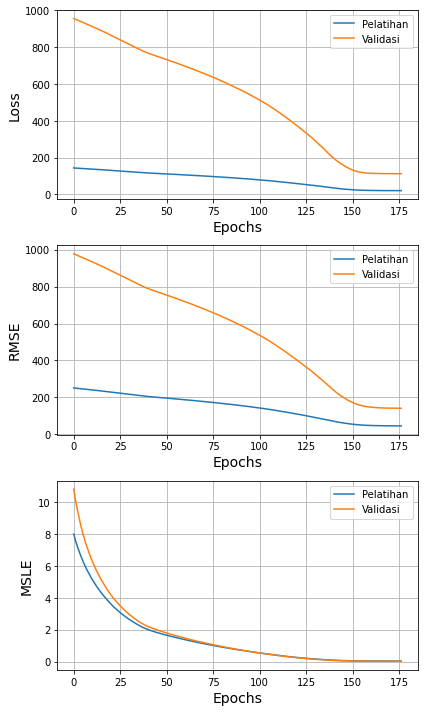

In [ ]:
plot_history(rho_history)

Model ANN untuk fase

In [ ]:
tf.keras.backend.clear_session()

phi_model = Sequential([
    layers.Dense(128, input_shape=[window_size], activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)                                         
])

phi_model.compile(
    optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9),
    loss = 'mae', 
    metrics = [keras.metrics.RootMeanSquaredError(), 'msle']
)

phi_history = phi_model.fit(
    train_phi, validation_data=val_phi,
    epochs=1000, verbose=1, callbacks=phiCallback()
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
7/7 [==============================] - 1s 36ms/step - loss: 29.6712 - root_mean_squared_error: 30.6209 - msle: 5.1131 - val_loss: 41.2322 - val_root_mean_squared_error: 42.0125 - val_msle: 5.4796
Epoch 2/1000
7/7 [==============================] - 0s 18ms/step - loss: 29.5423 - root_mean_squared_error: 30.4934 - msle: 4.9454 - val_loss: 40.9811 - val_root_mean_squared_error: 41.7592 - val_msle: 5.2209
Epoch 3/1000
7/7 [==============================] - 0s 20ms/step - loss: 29.3406 - root_mean_squared_error: 30.2897 - msle: 4.7019 - val_loss: 40.6668 - val_root_mean_squared_error: 41.4420 - val_msle: 4.9245
Epoch 4/1000
7/7 [==============================] - 0s 17ms/step - loss: 29.1022 - root_mean_squared_error: 30.0482 - msle: 4.4395 - val_loss: 40.3167 - val_root_mean_squared_error: 41.0889 - val_msle: 4.6256
Epoch 5/1000
7/7 [==============================] - 0s 17ms/step - loss: 28.8448 - root_mean_squared_error: 29.7869 - msle: 4.1810 - val_loss: 39.9495 - val_root_me

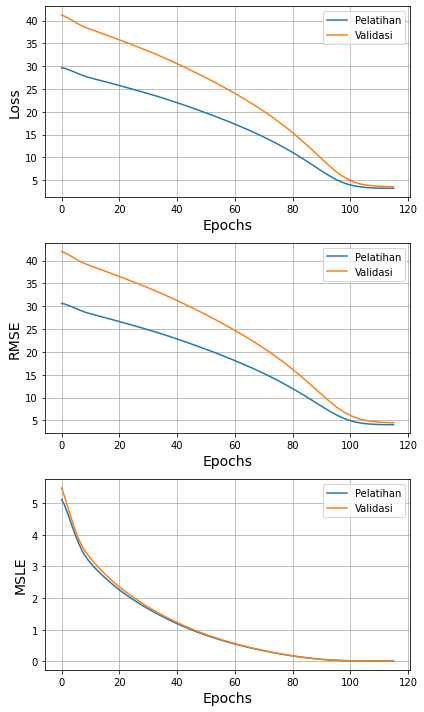

In [ ]:
plot_history(phi_history)

In [ ]:
rho_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/rho_model.h5')
phi_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/phi_model.h5')

In [ ]:
rho_forecast = model_forecast(rho_model, rho)
phi_forecast = model_forecast(phi_model, phi)

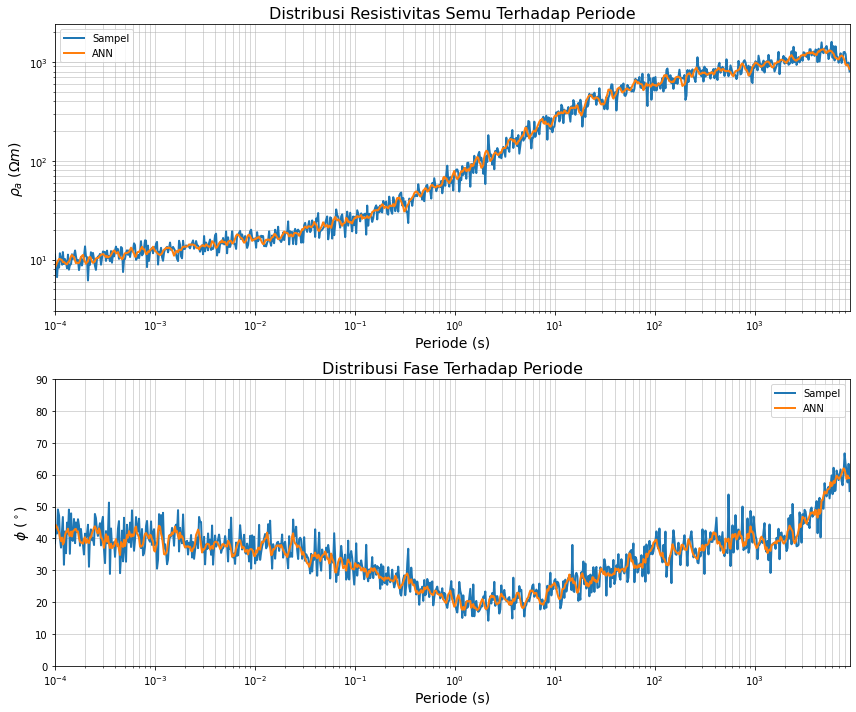


Rho MAE: 34.19 	Phi MAE: 2.64


In [ ]:
plot_res_phase(period[:-window_size], rho[:-window_size], phi[:-window_size], 
               rho_forecast,  phi_forecast, tp1='-', tp2='-', forecast=True)

rho_error = error(rho[:-window_size], rho_forecast)
phi_error = error(phi[:-window_size], phi_forecast)
print('\nRho MAE: {:0.2f} \tPhi MAE: {:0.2f}'.format(rho_error, phi_error))

In [ ]:
rho_model.save('rho_model.h5')
phi_model.save('phi_model.h5')